In [33]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt

from datetime import datetime
from dateutil.relativedelta import relativedelta

import tensorflow as tf
tf.random.set_seed(999)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
#from tensorflow.keras.regularizers import L1
#from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import KFold

### Data Handling

In [34]:
panel = pd.read_pickle('Data/returns_chars_panel.pkl') # all the stocks over all the time
#file too large, download it into D disk.
macro = pd.read_pickle('Data/macro_timeseries.pkl')   # macro indices

In [35]:
display(panel.head(), macro.head())

,date,permno,excess_ret,ret,rfree,mvel1,beta,betasq,chmom,dolvol,...,stdacc,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade
0,1986-02-01,10000,-0.262610,-0.257143,0.005467,-0.375440,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.572822,0.361538,0.938929,0.873640,0.399871,0.120000,-0.177810
1,1986-03-01,10000,0.360335,0.365385,0.005050,-0.496811,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.417504,0.520205,-0.138898,0.328870,0.078782,-0.411202,0.130393
2,1986-04-01,10000,-0.103717,-0.098592,0.005125,-0.401783,0.0,0.0,0.0,-0.521182,...,0.0,0.0,0.0,0.091488,0.329401,0.813365,0.660035,0.142035,-0.131985,0.119017
3,1986-05-01,10000,-0.227831,-0.222656,0.005175,-0.435735,0.0,0.0,0.0,-0.439391,...,0.0,0.0,0.0,0.329949,0.438295,-0.683852,-0.759048,0.388029,-0.199555,0.135402
4,1986-06-01,10000,-0.009883,-0.005025,0.004858,-0.534203,0.0,0.0,0.0,-0.499678,...,0.0,0.0,0.0,0.510140,0.610586,0.724257,0.608819,-0.128302,-0.025964,0.007879


,date,dp,ep,b/m,crsp_spvw,svar,tbl,tms,dfy,dfr,ntis,infl
671,1926-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
672,1927-01-01,-2.973012,-2.386837,0.441476,0.026047,0.000465,0.0307,0.0047,0.0100,-0.0022,0.050876,0.000000
673,1927-02-01,-2.942374,-2.374773,0.443706,-0.002910,0.000470,0.0323,0.0028,0.0095,-0.0019,0.050824,-0.011299
674,1927-03-01,-2.979535,-2.430353,0.428501,0.045522,0.000287,0.0329,0.0018,0.0092,-0.0019,0.051668,-0.005714
675,1927-04-01,-2.976535,-2.445079,0.469765,0.007324,0.000924,0.0320,0.0011,0.0092,-0.0170,0.046357,-0.005747


Note: the above dates are not in a chronological order. 'panel' data starts from 1957-03.

- Group stock-level characteristics and macro variables together.
- Define Features (X) and Targets (Y).<br> 
Note: the paper did not use macro variable 'crsp_spvw', 'dfr' and 'infl' so we will drop these out as well

In [36]:
# combine micro and macro data
# In the paper, the variables [crsp_spvw, dfr, infl] are not used
df = pd.merge(panel,macro.drop(columns=['crsp_spvw','dfr','infl']),on='date',how='left',suffixes=['','_macro'])
df.shape

(3739449, 107)

In [37]:
# to save the storing space
del panel, macro

In [38]:
df['permno'].nunique()

29853

In [39]:
# there are 84 industrial codes (first two digits of the original codes) 
df['permno'] = df['permno'].astype('str').str[:2]

inds = df['permno'].unique()
print(inds)
print(len(inds))

['10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '21' '22' '23'
 '24' '25' '26' '27' '28' '29' '30' '31' '32' '33' '34' '35' '36' '37'
 '38' '39' '40' '41' '42' '43' '44' '45' '46' '47' '48' '49' '50' '51'
 '52' '53' '54' '55' '56' '57' '58' '59' '60' '61' '62' '63' '64' '65'
 '66' '67' '68' '69' '70' '71' '72' '73' '74' '75' '76' '77' '78' '79'
 '80' '81' '82' '83' '84' '85' '86' '87' '88' '89' '90' '91' '92' '93']
84


In [40]:
# convert the industrial code to dummies and merge to the dataframe. Keep k-1 ind dummies to avoid multi-colinearity
ind_dummies = pd.get_dummies(df['permno'], prefix="ind", drop_first=True)
df = pd.concat([df,ind_dummies], axis=1)
df.shape

(3739449, 190)

In [41]:
df.head()

,date,permno,excess_ret,ret,rfree,mvel1,beta,betasq,chmom,dolvol,...,ind_84,ind_85,ind_86,ind_87,ind_88,ind_89,ind_90,ind_91,ind_92,ind_93
0,1986-02-01,10,-0.262610,-0.257143,0.005467,-0.375440,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1986-03-01,10,0.360335,0.365385,0.005050,-0.496811,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,1986-04-01,10,-0.103717,-0.098592,0.005125,-0.401783,0.0,0.0,0.0,-0.521182,...,0,0,0,0,0,0,0,0,0,0
3,1986-05-01,10,-0.227831,-0.222656,0.005175,-0.435735,0.0,0.0,0.0,-0.439391,...,0,0,0,0,0,0,0,0,0,0
4,1986-06-01,10,-0.009883,-0.005025,0.004858,-0.534203,0.0,0.0,0.0,-0.499678,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# features (X) + targets (Y)
# Note: for X, use everything except return info and IDs
#X = df.drop(columns=['ret', 'excess_ret', 'rfree', 'permno', 'date'])
X = df.drop(columns=['ret', 'excess_ret', 'rfree', 'permno']) 
y = df['excess_ret']

### Exploring ways to do time series cross validation:

In [139]:
def custom_time_series_split(start_year, end_year, train_size, val_size, test_size, step=1):
    current_year = start_year
    while current_year + train_size + val_size + test_size <= end_year:
        
        train_start = start_year
        train_end = current_year + train_size
        
        val_start = train_end
        val_end = val_start + val_size
        
        test_start = val_end
        test_end = test_start + test_size

        yield np.arange(train_start, train_end), np.arange(val_start, val_end), np.arange(test_start, test_end)

        current_year += step

In [140]:
start_year = 1957
end_year = 2017
train_size = 18  # Number of years in the training set
val_size = 12    # Number of years in the validation set
test_size = 1    # Number of years in the test set

for i, (train_year, val_year, test_year) in enumerate(custom_time_series_split(start_year, end_year, train_size, val_size, test_size)):
    print(f"Fold {i}:")
    
    #train_set = your_data[train_index]
    print(f"Train year: index={train_year}")
    
    #val_set = your_data[val_index]
    print(f"Validation year:  index={val_year}")
    
    #test_set = your_data[test_index]
    print(f"Test year:  index={test_year}\n")

Fold 0:
Train year: index=[1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974]
Validation year:  index=[1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986]
Test year:  index=[1987]

Fold 1:
Train year: index=[1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975]
Validation year:  index=[1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987]
Test year:  index=[1988]

Fold 2:
Train year: index=[1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976]
Validation year:  index=[1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988]
Test year:  index=[1989]

Fold 3:
Train year: index=[1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970
 1971 1972 1973 1974 1975 1976 1977]
Validation year:  index=[1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989]
Test year:  index=[1990]

Fold 4:
Train year: index=[1957 1958 1959 1960

**Time series cross validation illustration plot:**

In [157]:
def get_tscv_plot(start_year, end_year, train_size, val_size, test_size, step=1):
    
    # Get all the date indexes for all the folds into a dictionary
    folds = []
    current_year = start_year
    
    while current_year + train_size + val_size + test_size <= end_year:
        
        train_start = start_year
        train_end = current_year + train_size
        
        val_start = train_end
        val_end = val_start + val_size
        
        test_start = val_end
        test_end = test_start + test_size

        date_info = {'train_start':start_year, 'train_end':train_end, 'val_start':val_start, 'val_end':val_end, 
                     'test_start':test_start, 'test_end':test_end}
        folds.append(date_info)
        current_year += step
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(16,8))

    # Set the y-axis ticks and labels
    y_ticks = range(1, len(folds) + 1)
    y_labels = [f'Fold {i}' for i in y_ticks[::-1]]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # Plot the bars for each fold
    i = 1
    for fold in folds[::-1]:
        train_start = int(fold['train_start'])
        train_end = int(fold['train_end'])
        val_start = int(fold['val_start'])
        val_end = int(fold['val_end'])
        test_start = int(fold['test_start'])
        test_end = int(fold['test_end'])

        ax.barh(i, train_end - train_start, left=train_start, height=0.5, color='blue', label='Train')
        ax.barh(i, val_end - val_start, left=val_start, height=0.5, color='orange', label='Validation')
        ax.barh(i, test_end - test_start, left=test_start, height=0.5, color='red', label='Test')
        i += 1

    # Set the x-axis limits and labels
    ax.set_xlim(int(folds[0]['train_start']), int(folds[-1]['test_end']))
    ax.set_xlabel('Year')

    # Add a legend
    handles = [plt.Rectangle((0, 0), 1, 1, color='blue'),
               plt.Rectangle((0, 0), 1, 1, color='orange'),
               plt.Rectangle((0, 0), 1, 1, color='red')]
    labels = ['Train', 'Validation', 'Test']
    ax.legend(handles, labels, loc='upper right')

    # Show the plot
    plt.show()
    
    return None

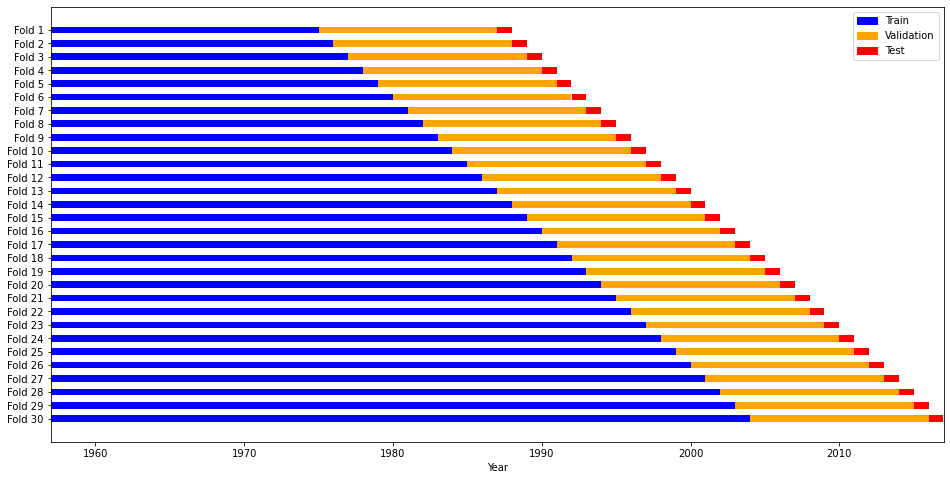

In [158]:
start_year = 1957
end_year = 2017
train_size = 18  # Number of years in the training set
val_size = 12    # Number of years in the validation set
test_size = 1    # Number of years in the test set

get_tscv_plot(start_year, end_year, train_size, val_size, test_size, step=1)

**Modified the above 'custom_time_series_split' function to make it compatible with datetime format:** 

In [79]:
def custom_ts_split(start_year, end_year, train_size, val_size, test_size, step=1):
    
    start_year_dt = datetime.strptime(start_year, '%Y-%m')
    end_year_dt = datetime.strptime(end_year, '%Y-%m')
    train_size_dt = relativedelta(years=train_size)
    val_size_dt = relativedelta(years=val_size)
    test_size_dt = relativedelta(years=test_size)
    step_dt = relativedelta(years=step)
    
    current_year = start_year_dt
    
    while current_year + train_size_dt + val_size_dt + test_size_dt <= end_year_dt:
        
        train_start = start_year_dt
        train_end = current_year + train_size_dt
        
        val_start = train_end
        val_end = val_start + val_size_dt
        
        test_start = val_end
        test_end = test_start + test_size_dt

        yield train_end, val_end, test_end

        current_year += step_dt

In [42]:
start_year = '1957-03'
end_year = '2017-03'
train_size = 18  # Number of years in the training set
val_size = 12    # Number of years in the validation set
test_size = 1    # Number of years in the test set

for i, (train_end, val_end, test_end) in enumerate(custom_ts_split(start_year, end_year, train_size, val_size, test_size)):
    print(f"Fold {i}:")
    
    #train_set = your_data[train_index]
    print(f"Train end: index={train_end}")
    
    #val_set = your_data[val_index]
    print(f"Validation end:  index={val_end}")
    
    #test_set = your_data[test_index]
    print(f"Test end:  index={test_end}\n")

Fold 0:
Train end: index=1975-03-01 00:00:00
Validation end:  index=1987-03-01 00:00:00
Test end:  index=1988-03-01 00:00:00

Fold 1:
Train end: index=1976-03-01 00:00:00
Validation end:  index=1988-03-01 00:00:00
Test end:  index=1989-03-01 00:00:00

Fold 2:
Train end: index=1977-03-01 00:00:00
Validation end:  index=1989-03-01 00:00:00
Test end:  index=1990-03-01 00:00:00

Fold 3:
Train end: index=1978-03-01 00:00:00
Validation end:  index=1990-03-01 00:00:00
Test end:  index=1991-03-01 00:00:00

Fold 4:
Train end: index=1979-03-01 00:00:00
Validation end:  index=1991-03-01 00:00:00
Test end:  index=1992-03-01 00:00:00

Fold 5:
Train end: index=1980-03-01 00:00:00
Validation end:  index=1992-03-01 00:00:00
Test end:  index=1993-03-01 00:00:00

Fold 6:
Train end: index=1981-03-01 00:00:00
Validation end:  index=1993-03-01 00:00:00
Test end:  index=1994-03-01 00:00:00

Fold 7:
Train end: index=1982-03-01 00:00:00
Validation end:  index=1994-03-01 00:00:00
Test end:  index=1995-03-01 00

**Potential code to tune hyperparameters if grid search unable to divide train, validation and test set as desired:** 

In [82]:
start_year = '1957-03'
end_year = '1989-03'
train_size = 18        # Number of years in the training set
val_size = 12          # Number of years in the validation set
test_size = 1          # Number of years in the test set

date = df["date"]

for i, (train_end, val_end, test_end) in enumerate(custom_ts_split(start_year, end_year, train_size, val_size, test_size)):
    
    print(f"Working with Fold {i}...")
    
    # Define training set
    training = (date <= train_end)
    X_train, y_train = X.loc[training], y.loc[training]
    
    # Define validation set
    validation = (date > train_end) & (date <= val_end) 
    X_val, y_val = X.loc[validation], y.loc[validation]
    
    # Define test set
    test = (date > val_end) & (date <= test_end)
    X_test, y_test = X.loc[test], y.loc[test]
    
    #for param1 in hyperparam_grid:
        #for param2 in hyperparam_grid:
            # Fit this set of params to NN2. E.g. model = fit_nn2(param1, param2, ..., X_train, y_train, X_val, y_val)
            # record hyperparam set + performance
    
    # Pick a hyperparam set with the best performance
    # Train this best model on (train + validation) set
    # Evaluate the model on test set, setting the performance metrix to R^2 OOS

Working with Fold 0...
Working with Fold 1...


### Functions to create models:

In [10]:
def create_nn2():
    
    # model architechture
    model = Sequential()
    
    # add layers
    model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    # compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    return model

In [11]:
def create_nn3():
    
    # model architechture
    model = Sequential()
    
    # add layers
    model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    # compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    return model

In [12]:
def create_nn4():
    
    # model architechture
    model = Sequential()
    
    # add layers
    model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    # compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    return model

### Functions to fit models:

In [13]:
def fit_nn2(X_train, y_train, X_val, y_val, epochs, batch_size):
    
    # model architechture
    model = Sequential()
    
    # add layers
    model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    # compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    # fit the model
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        verbose=False,
                        validation_data = (X_val, y_val))
    return history

**Example of performing grid search on JUST ONE set of training and validating data**
<br> Can Ignore this

In [14]:
# features (X) + targets (Y)
# Note: for X, use everything except return info and IDs
X = df.drop(columns=['ret', 'excess_ret', 'rfree', 'permno', 'date']) 
y = df['excess_ret']

In [15]:
print(X.shape, y.shape)

(3739449, 185) (3739449,)


In [56]:
# Note: below represents just ONE set of training and testing within an expanding window time-series cross validation
# e.g. make 4 years of training data
date = df['date']
training = (date <= '1975-03') # selects 
X_train, y_train = X.loc[training], y.loc[training]

# e.g. make 2 years of validation data
validation = (date > '1975-03') & (date <= '1987-03') 
X_val, y_val = X.loc[validation], y.loc[validation]

# make test data (ignore for now)
test = (date > '1987-03') & (date <= '1988-03')
X_test, y_test = X.loc[test], y.loc[test]

In [65]:
X_test['date'].max()

Timestamp('1988-03-01 00:00:00')

In [55]:
# Note: below represents just ONE set of training and testing within an expanding window time-series cross validation
# e.g. make 4 years of training data
date = df['date']
training = (date <= '1975-03') # selects 
X_train, y_train = X.loc[training].values, y.loc[training].values

# e.g. make 2 years of validation data
validation = (date > '1975-03') & (date <= '1987-03') 
X_val, y_val = X.loc[validation].values, y.loc[validation].values 

# make test data (ignore for now)
test = (date > '1987-03') & (date <= '1988-03')
X_test, y_test = X.loc[test].values, y.loc[test].values

In [ ]:
display(X_train.shape, X_val.shape)

In [ ]:
# Create the model and wrap it in a KerasRegressor for compatibility with scikit-learn
model = KerasRegressor(model=create_nn2, verbose=0)

# Define the parameter grid for hyperparameter tuning
batch_size = [10, 20, 40]
epochs = [10, 20, 30]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Perform grid search for hyperparameter tuning
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=2)
grid_result = grid.fit(X_train, y_train)

In [ ]:
# summarize results
print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Summary dataframe showing all combinations
df = pd.DataFrame(grid_result.cv_results_)
df[['param_batch_size', 'param_epochs', 'mean_test_score']]

In [ ]:
# store best model
best_model = grid_result.best_estimator_
best_params = grid_result.best_params_

display(best_model, best_params)

In [ ]:
# Train the best model using the training data
best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

# Evaluate it on validation set
y_pred = best_model.predict(X_val)
score = mean_squared_error(y_val, y_pred)
print(f"Evaluation score: {score}")

In [ ]:
# Train the best model using training set and evaluate it on validation set
#fit_nn2(X_train, y_train, X_val, y_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'])